# Classifying Knee Images

## 1 Setup

### 1.1 Imports

In [1]:
# omit tensorflow import futurewarnings
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
print('TensorFlow version: ', tf.__version__)

from tensorflow import keras
from tensorflow.keras import Model, preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalMaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from tensorflow.keras.applications import DenseNet201, Xception

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

TensorFlow version:  2.5.0


### 1.2 Constants

In [2]:
BATCH_SIZE = 32
TARGET_IMG_HEIGHT = 150
TARGET_IMG_WIDTH = 150
CLASS_MODE_SPARSE = 'sparse'
INTERPOLATION_BILINEAR = 'bilinear'

## 2 Load the data

## 2.1 Different loading criteria
Code will differ based on whether we are running on Google Colab or on a local machine

### 2.1.1 On local machine

In [3]:
# directory = "../data/"

### 2.1.2 On Google Colab

In [4]:
!wget --no-check-certificate \
    "https://github.com/fontainelam/KneeOsteoarthritis/archive/refs/heads/main.zip" \
    -O "/tmp/knee-data.zip"

zip_ref = zipfile.ZipFile('/tmp/knee-data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2021-06-28 04:35:30--  https://github.com/fontainelam/KneeOsteoarthritis/archive/refs/heads/main.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/fontainelam/KneeOsteoarthritis/zip/refs/heads/main [following]
--2021-06-28 04:35:30--  https://codeload.github.com/fontainelam/KneeOsteoarthritis/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/knee-data.zip’

/tmp/knee-data.zip      [        <=>         ] 173.85M  34.9MB/s    in 5.6s    

2021-06-28 04:35:36 (31.3 MB/s) - ‘/tmp/knee-data.zip’ saved [182296411]



In [5]:
!ls /tmp/KneeOsteoarthritis-main/data/

test  train  val


In [6]:
os.listdir("/tmp/KneeOsteoarthritis-main/data/")

['val', 'train', 'test']

In [7]:
directory = "/tmp/KneeOsteoarthritis-main/data/"

## 2.2 Load files

In [8]:
train_directory = directory + "train"
val_directory = directory + "val"
test_directory = directory + "test"

In [9]:
# create a normal, non-augmented data generator
datagen_normal = ImageDataGenerator()

# create an augmented data generator
# since we will be processing Knee X-rays, we will allow the following augmentations:
# vertical flipping, zooming, rotating, shearing, brightness
datagen_augment = ImageDataGenerator(rotation_range=10,
                                     #width_shift_range=0.2,
                                     #height_shift_range=0.2,
                                     brightness_range=[0.3,0.9],
                                     shear_range=0.25,
                                     zoom_range=0.1,
                                     channel_shift_range = 20,
                                     horizontal_flip = True,
                                     fill_mode='constant')

In [10]:
def get_image_data_from_directory( dir_path, augment_data_param = False, shuffle_param = False):
    datagen = datagen_augment if augment_data_param == True else datagen_normal
    return datagen.flow_from_directory(
        dir_path,
        target_size=(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=shuffle_param,
        class_mode=CLASS_MODE_SPARSE,
        interpolation=INTERPOLATION_BILINEAR)

### 2.2.1 Load training set

In [11]:
# augment data and shuffle the training dataset
train_generator = get_image_data_from_directory(train_directory, True, True) 

Found 5778 images belonging to 5 classes.


### 2.2.2 Load validation set

In [12]:
val_generator = get_image_data_from_directory(val_directory)

Found 826 images belonging to 5 classes.


### 2.2.3 Load test set

In [13]:
test_generator = get_image_data_from_directory(test_directory) 

Found 1656 images belonging to 5 classes.


### 2.2.4 Get files for use with distribution plots and samples

In [14]:
def fetch_files_from_directory( dir_path ):
  file_dict = {}
  for grade in os.listdir( dir_path ):
    file_dict[grade] = os.listdir(dir_path + '/' + grade)
  return file_dict

In [15]:
train_files = fetch_files_from_directory(train_directory)
val_files = fetch_files_from_directory(val_directory)
test_files = fetch_files_from_directory(test_directory)

## 3 Explore the data

In [16]:
print('Training data: contains {} images, batch size of {}'.format(train_generator.n, train_generator.batch_size))
print('Validation data: contains {} images, batch size of {}'.format(val_generator.n, val_generator.batch_size))
print('Testing data: contains {} images, batch size of {}'.format(test_generator.n, test_generator.batch_size))

Training data: contains 5778 images, batch size of 32
Validation data: contains 826 images, batch size of 32
Testing data: contains 1656 images, batch size of 32


In [17]:
sns.set_style("dark")

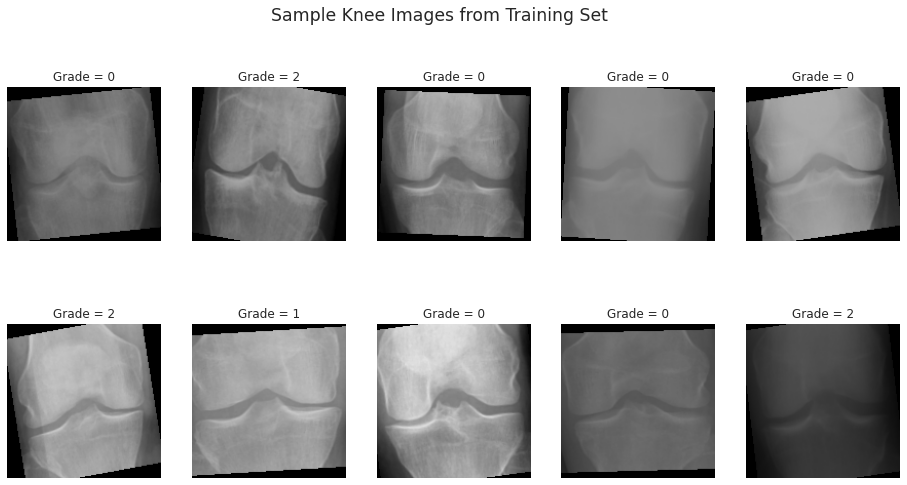

In [18]:
plt.figure(figsize=(16, 8))
for i in range(1):
    images, labels = next(train_generator)
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        ax.axis('off')
        plt.imshow(images[i].squeeze().astype('uint8'),cmap='gray')
        ax.set_title('Grade = ' + str(int(labels[i])))
_ = plt.suptitle('Sample Knee Images from Training Set', size='xx-large')

train_generator.reset()

In [19]:
def plot_distribution(set_of_files, title):
    f, ax = plt.subplots(figsize=(16,6))
    keys = sorted(list(set_of_files.keys()))
    vals = [len(set_of_files[k]) for k in keys]
    sns.barplot(x=keys, y=vals, palette="Blues_d")
    plt.xlabel('Knee Severity Grade')
    plt.title(title)

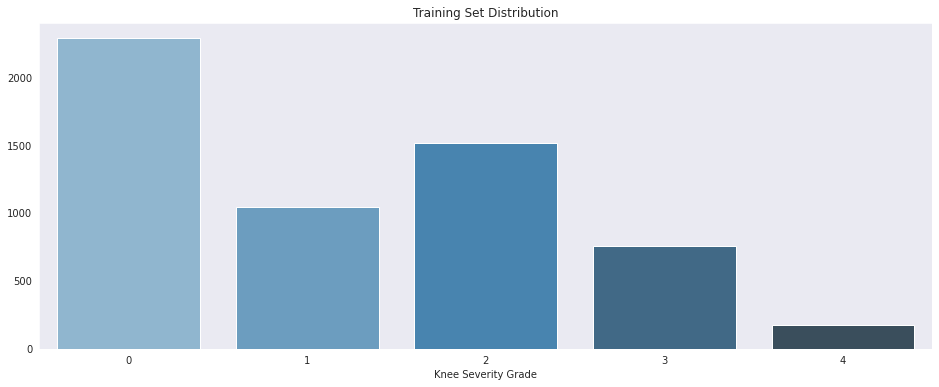

In [20]:
plot_distribution(train_files, 'Training Set Distribution')

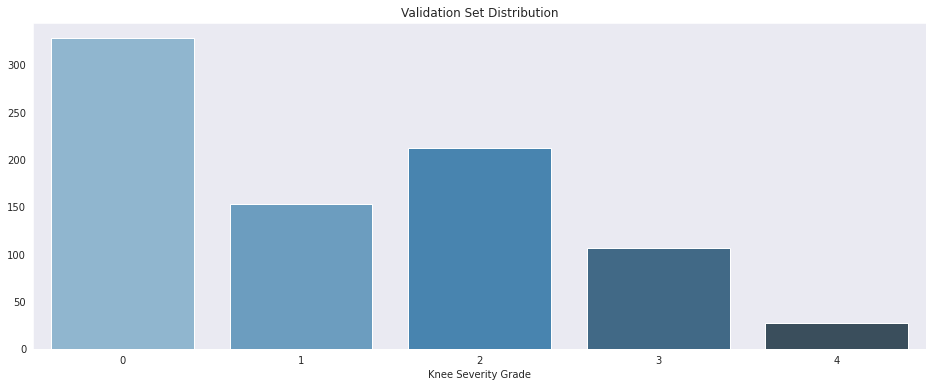

In [21]:
plot_distribution(val_files, 'Validation Set Distribution')

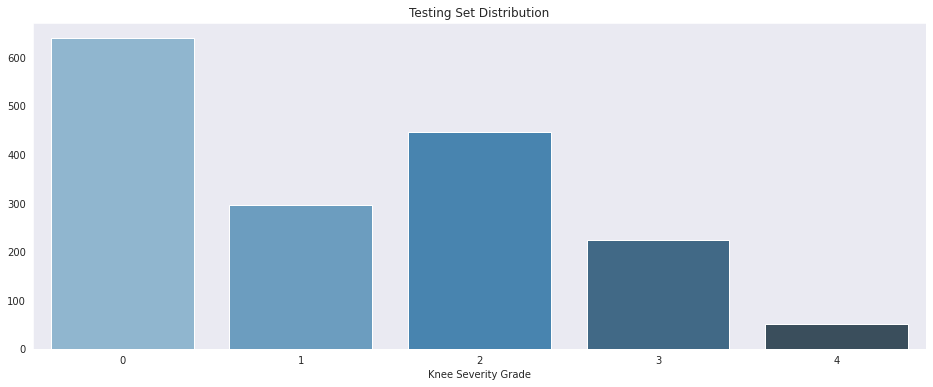

In [22]:
plot_distribution(test_files, 'Testing Set Distribution')

## 4 Model - Transfer Learning - DenseNet201

### 4.1 Building the model

In [23]:
img_height = 150
img_width = 150

base_model = DenseNet201(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

74842112/74836368 [==============================] - 1s 0us/step


In [24]:
base_model.trainable = False

In [25]:
inputs = Input(shape=(img_height, img_width, 3))

## for DenseNet, add a rescaling layer to input
x = Rescaling(1./255)(inputs)

x = base_model(x, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = GlobalMaxPooling2D()(x)

x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)

num_classes = 5

outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

In [26]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
global_max_pooling2d (Global (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1967104   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125  

Since we can see from our earlier distribution plots that we have imbalanced data, we will use __class weights__ to aid our model.

In [28]:
train_labels_from_files = []
for k, v in train_files.items():
    num_files = len(v)
    print('grade', k, 'contains', num_files, 'images')
    train_labels_from_files.extend([int(k)]* num_files)
print('total number of images:', len(train_labels_from_files))

grade 3 contains 757 images
grade 2 contains 1516 images
grade 1 contains 1046 images
grade 4 contains 173 images
grade 0 contains 2286 images
total number of images: 5778


In [29]:
class_weights_dict = dict(enumerate(class_weight.compute_class_weight(class_weight='balanced', classes=np.asarray(range(5)), y=train_labels_from_files)))
print(class_weights_dict)

{0: 0.5055118110236221, 1: 1.1047801147227534, 2: 0.7622691292875989, 3: 1.5265521796565389, 4: 6.679768786127168}


### 4.2 Initial model fitting

In [30]:
num_epochs = 12

step_size_train = train_generator.n // train_generator.batch_size + 1
step_size_val = val_generator.n // val_generator.batch_size + 1

history = model.fit(train_generator, 
                    steps_per_epoch = step_size_train,
                    validation_data = val_generator, 
                    validation_steps = step_size_val,
                    epochs = num_epochs, 
                    class_weight = class_weights_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/12
181/181 [==============================] - 69s 248ms/step - loss: 2.0649 - accuracy: 0.2707 - val_loss: 1.3492 - val_accuracy: 0.3487
Epoch 2/12
181/181 [==============================] - 42s 234ms/step - loss: 1.4721 - accuracy: 0.3070 - val_loss: 1.2897 - val_accuracy: 0.4080
Epoch 3/12
181/181 [==============================] - 42s 232ms/step - loss: 1.4238 - accuracy: 0.3195 - val_loss: 1.3058 - val_accuracy: 0.2772
Epoch 4/12
181/181 [==============================] - 42s 232ms/step - loss: 1.4122 - accuracy: 0.3287 - val_loss: 1.3827 - val_accuracy: 0.3535
Epoch 5/12
181/181 [==============================] - 42s 235ms/step - loss: 1.3642 - accuracy: 0.3397 - val_loss: 1.2567 - val_accuracy: 0.3354
Epoch 6/12
181/181 [==============================] - 42s 233ms/step - loss: 1.3560 - accuracy: 0.3382 - val_loss: 1.2523 - val_accuracy:

#### 4.2.1 Initial model - Training and Validation Accuracy and Loss

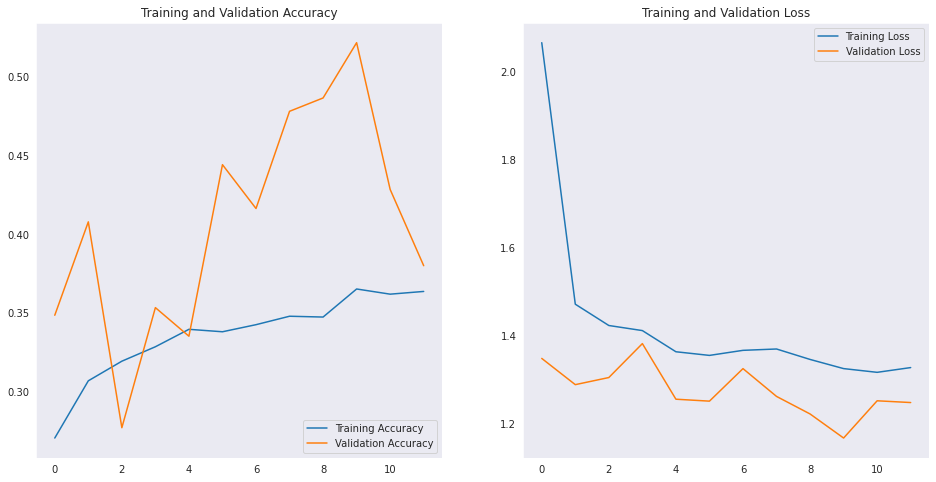

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 4.2.2 Initial model - Predictions on test set

In [32]:
initial_test_loss, initial_test_accuracy = model.evaluate(test_generator)

52/52 [==============================] - 5s 89ms/step - loss: 1.2519 - accuracy: 0.3617


##### 4.2.2.1 Initial model - Model accuracy

In [33]:
print('Accuracy of initial model on test set: {:.2f} percent'.format(100*initial_test_accuracy))

Accuracy of initial model on test set: 36.17 percent


##### 4.2.2.2 Initial model - Confusion matrix

In [34]:
test_generator.reset()
Y_pred = model.predict(test_generator, steps=(test_generator.n // test_generator.batch_size)+1)
y_pred = np.argmax(Y_pred, axis=1)

In [35]:
cm = confusion_matrix(test_generator.classes, y_pred)
cm

array([[164, 414,  31,  27,   3],
       [ 54, 191,  32,  18,   1],
       [ 27, 200, 107,  82,  31],
       [  2,  59,  22,  97,  43],
       [  0,   0,   2,   9,  40]])

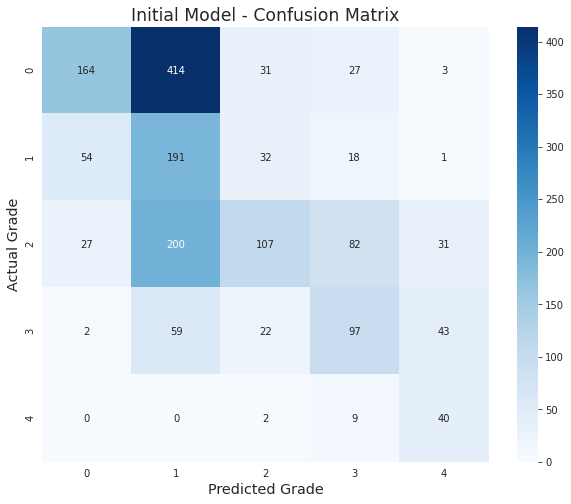

In [36]:
plt.figure(figsize=(10, 8))
_ = sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')
plt.xlabel('Predicted Grade', size='x-large')
plt.ylabel('Actual Grade', size='x-large')
_ = plt.title('Initial Model - Confusion Matrix',size='xx-large')

##### 4.2.2.3 Initial model - Classification Report

In [37]:
print("Initial model - Classification Report:")
clr = classification_report(test_generator.classes, y_pred, zero_division=0)
print(clr)

Initial model - Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.26      0.37       639
           1       0.22      0.65      0.33       296
           2       0.55      0.24      0.33       447
           3       0.42      0.43      0.43       223
           4       0.34      0.78      0.47        51

    accuracy                           0.36      1656
   macro avg       0.44      0.47      0.39      1656
weighted avg       0.51      0.36      0.36      1656



#### 4.2.3 Sample images from test set

We will randomly fetch 5 image files from each of the 5 classes to load and display with their actual grade along with their predicted grade.

In [38]:
from random import sample

test_sample_files = []

# randomly fetch the files
for i in range(5):
    class_name = str(i)
    for file_name in sample(test_files[class_name], 5):
        test_sample_files.append( (class_name, file_name) )
test_sample_files.sort()

In [39]:
# load the images
test_sample_images = []
test_sample_actual_labels = []
for i, (class_name, file_name) in enumerate(test_sample_files):
    img_path = test_directory + '/' + class_name + '/' + file_name
    img = image.load_img(img_path, target_size=(150,150), interpolation='bilinear')
    x = image.img_to_array(img)
    test_sample_images.append(x)
    test_sample_actual_labels.append(int(class_name))
    
# convert list into numpy array
test_sample_images = np.asarray(test_sample_images)

In [40]:
# run the prediction
test_sample_predictions = model.predict(test_sample_images)
test_sample_prediction_labels = test_sample_predictions.argmax(axis=1)

In [41]:
test_sample_accuracy_score = 100 * np.sum(test_sample_actual_labels == test_sample_prediction_labels)/len(test_sample_files)
print('Accuracy of initial model: {:.2f} percent'.format(test_sample_accuracy_score))

Accuracy of initial model: 52.00 percent


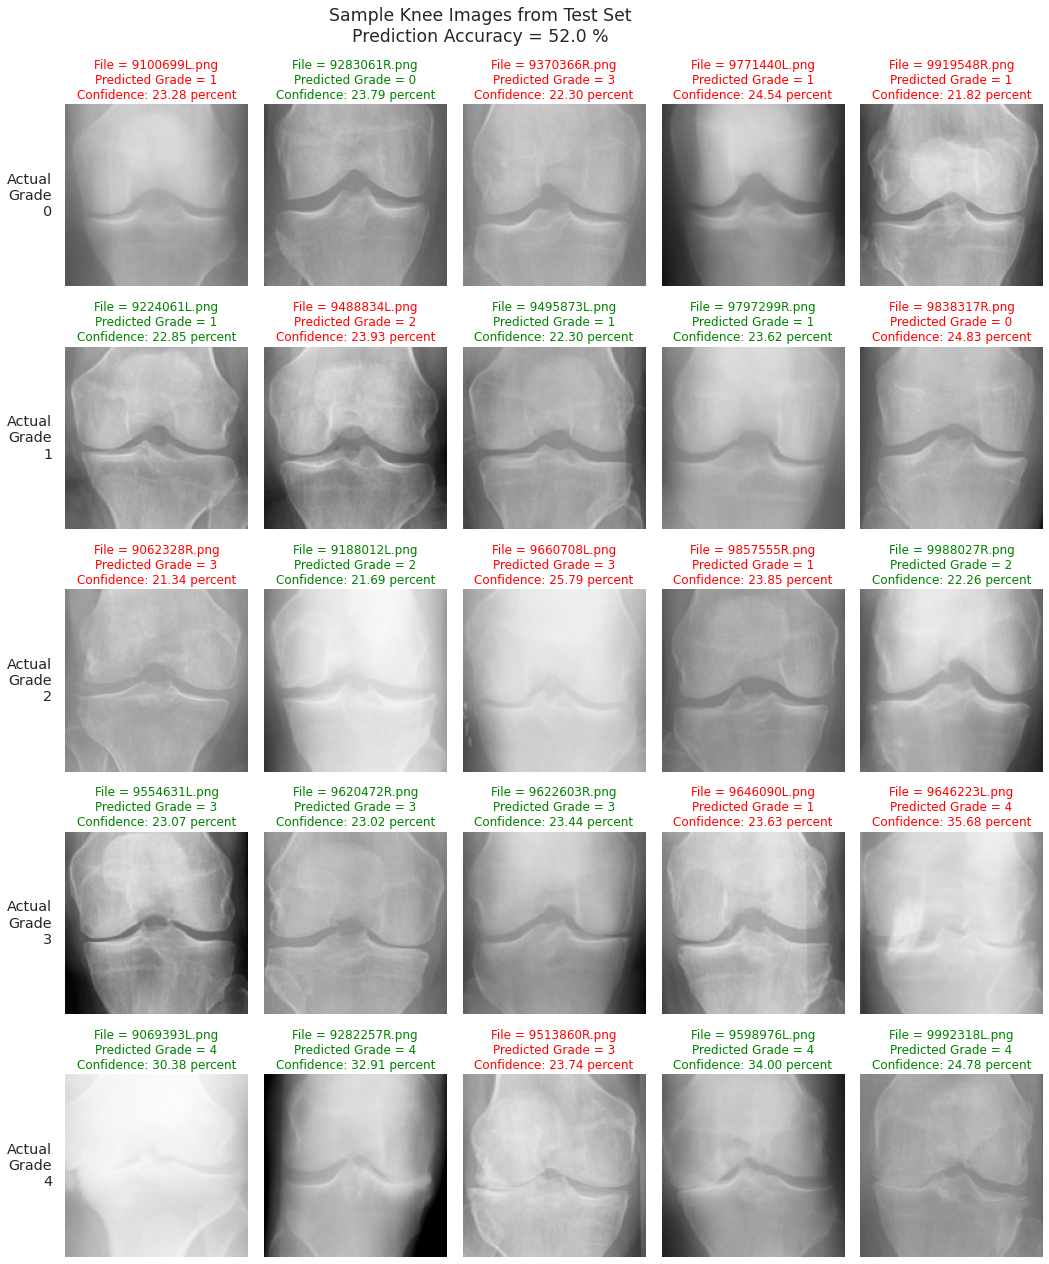

In [42]:
# plot the images

rows = ['Actual\nGrade\n{}'.format(grade) for grade in range(5)]

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(16, 18))

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.05), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='x-large', ha='right', va='center')

for i in range(5):
    for j in range(5):
        img_num = i*5 + j
        ax = axes[i, j]
        
        # can't just turn off the axis if we want to keep y label
        # must turn each element of axis off
        ax.xaxis.set_visible(False)
        plt.setp(ax.spines.values(), visible=False)
        ax.tick_params(left=False, labelleft=False)
        
        ax.imshow(test_sample_images[img_num].squeeze().astype('uint8'))
        
        file_name = test_sample_files[img_num][1]
        pred_grade = test_sample_prediction_labels[img_num]
        score = 100*np.max(tf.nn.softmax(test_sample_predictions[img_num]))
        title = "File = {}\nPredicted Grade = {}\nConfidence: {:.2f} percent".format(file_name, pred_grade, score)
        
        # if correctly predicted, set title color to green
        # note that i == actual grade
        title_color = 'green' if pred_grade == i else 'red'
        ax.set_title(title, color=title_color) 
_ = plt.suptitle('Sample Knee Images from Test Set\nPrediction Accuracy = {} %'.format(test_sample_accuracy_score), size='xx-large')
plt.tight_layout(rect=[0.08, 0, 1, 0.95])

### 4.3 Fine-tuning the model

We will now iterate through each layer of the base model (DenseNet201) and freeze all layers except for the last 4. This will allow us to fine-tune the model.

We will also reduce the learning rate to 1e-5, or 0.00001, and increase the number of epochs to 30.

In [43]:
base_model.trainable = True
for layer in base_model.layers[:-4]:
    base_model.trainable = False

In [44]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

In [45]:
num_epochs = 30

step_size_train = train_generator.n // train_generator.batch_size + 1
step_size_val = val_generator.n // val_generator.batch_size + 1

history = model.fit(train_generator, 
                    steps_per_epoch = step_size_train,
                    validation_data = val_generator, 
                    validation_steps = step_size_val,
                    epochs = num_epochs, 
                    class_weight = class_weights_dict)

Epoch 1/30
181/181 [==============================] - 53s 247ms/step - loss: 1.3233 - accuracy: 0.3041 - val_loss: 1.2357 - val_accuracy: 0.4201
Epoch 2/30
181/181 [==============================] - 42s 232ms/step - loss: 1.2847 - accuracy: 0.3371 - val_loss: 1.2288 - val_accuracy: 0.4419
Epoch 3/30
181/181 [==============================] - 42s 232ms/step - loss: 1.3074 - accuracy: 0.3375 - val_loss: 1.2247 - val_accuracy: 0.4552
Epoch 4/30
181/181 [==============================] - 42s 232ms/step - loss: 1.3364 - accuracy: 0.3536 - val_loss: 1.2230 - val_accuracy: 0.4625
Epoch 5/30
181/181 [==============================] - 42s 233ms/step - loss: 1.2982 - accuracy: 0.3628 - val_loss: 1.2217 - val_accuracy: 0.4661
Epoch 6/30
181/181 [==============================] - 42s 231ms/step - loss: 1.3158 - accuracy: 0.3595 - val_loss: 1.2202 - val_accuracy: 0.4685
Epoch 7/30
181/181 [==============================] - 42s 230ms/step - loss: 1.3190 - accuracy: 0.3719 - val_loss: 1.2219 - val_ac

#### 4.3.1 After fine-tuning model - Training and Validation Accuracy and Loss

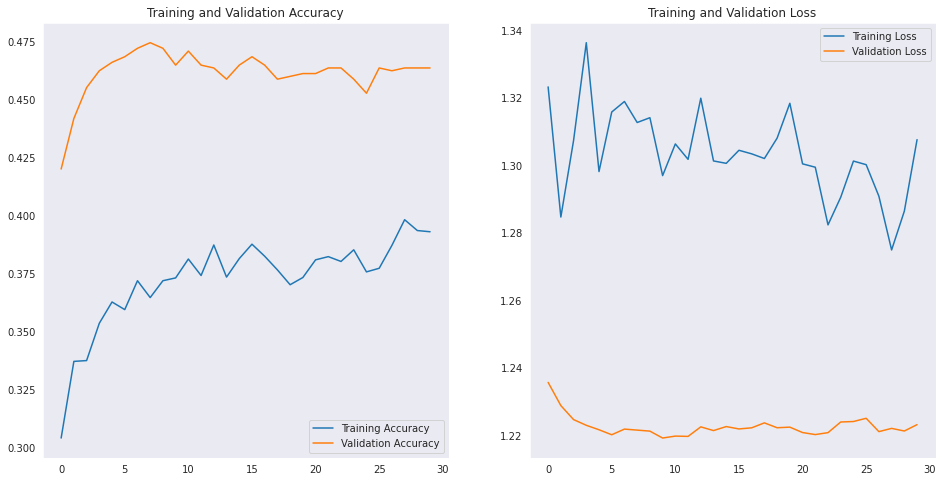

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 4.3.2 After fine-tuning model - Predictions on test set

In [47]:
test_generator.reset()
test_loss, test_accuracy = model.evaluate(test_generator)

52/52 [==============================] - 4s 76ms/step - loss: 1.2217 - accuracy: 0.4372


##### 4.3.2.1 After fine-tuning model - Model accuracy

In [48]:
print('Accuracy of fine-tuned model on test set: {:.2f} percent'.format(100*test_accuracy))

Accuracy of fine-tuned model on test set: 43.72 percent


##### 4.3.2.2 After fine-tuning model - Confusion matrix

In [49]:
test_generator.reset()
Y_pred = model.predict(test_generator, steps=(test_generator.n // test_generator.batch_size)+1)
y_pred = np.argmax(Y_pred, axis=1)

In [50]:
cm = confusion_matrix(test_generator.classes, y_pred)
cm

array([[322, 220,  62,  32,   3],
       [101, 104,  72,  19,   0],
       [ 68, 117, 161,  82,  19],
       [ 14,  38,  36, 102,  33],
       [  0,   0,   6,  10,  35]])

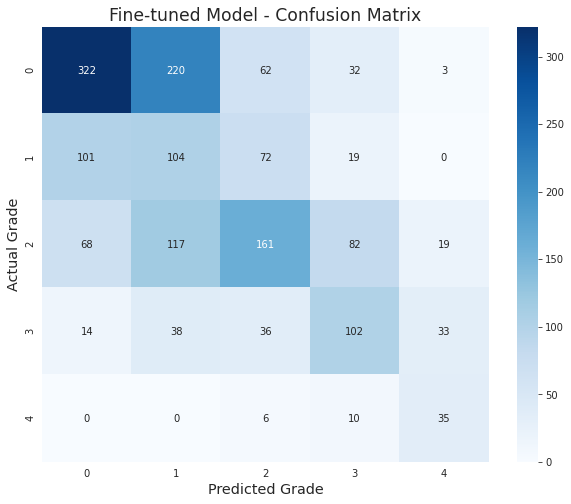

In [51]:
plt.figure(figsize=(10, 8))
_ = sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')
plt.xlabel('Predicted Grade', size='x-large')
plt.ylabel('Actual Grade', size='x-large')
_ = plt.title('Fine-tuned Model - Confusion Matrix',size='xx-large')

##### 4.3.2.3 After fine-tuning model - Classification Report

In [52]:
print("Fine-tuned model - Classification Report:")
clr = classification_report(test_generator.classes, y_pred, zero_division=0)
print(clr)

Fine-tuned model - Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.50      0.56       639
           1       0.22      0.35      0.27       296
           2       0.48      0.36      0.41       447
           3       0.42      0.46      0.44       223
           4       0.39      0.69      0.50        51

    accuracy                           0.44      1656
   macro avg       0.43      0.47      0.43      1656
weighted avg       0.48      0.44      0.45      1656



#### 4.3.3 Sample images from test set - after fine-tuning

We will look at the same sample images we earlier retrieved and the grades we now assign.

In [53]:
# run the prediction
fine_tuned_test_sample_predictions = model.predict(test_sample_images)
fine_tuned_test_sample_prediction_labels = fine_tuned_test_sample_predictions.argmax(axis=1)

In [54]:
fine_tuned_test_sample_accuracy_score = 100 * np.sum(test_sample_actual_labels == fine_tuned_test_sample_prediction_labels)/len(test_sample_files)
print('Accuracy of fine-tuned model: {:.2f} percent'.format(fine_tuned_test_sample_accuracy_score))

Accuracy of fine-tuned model: 52.00 percent


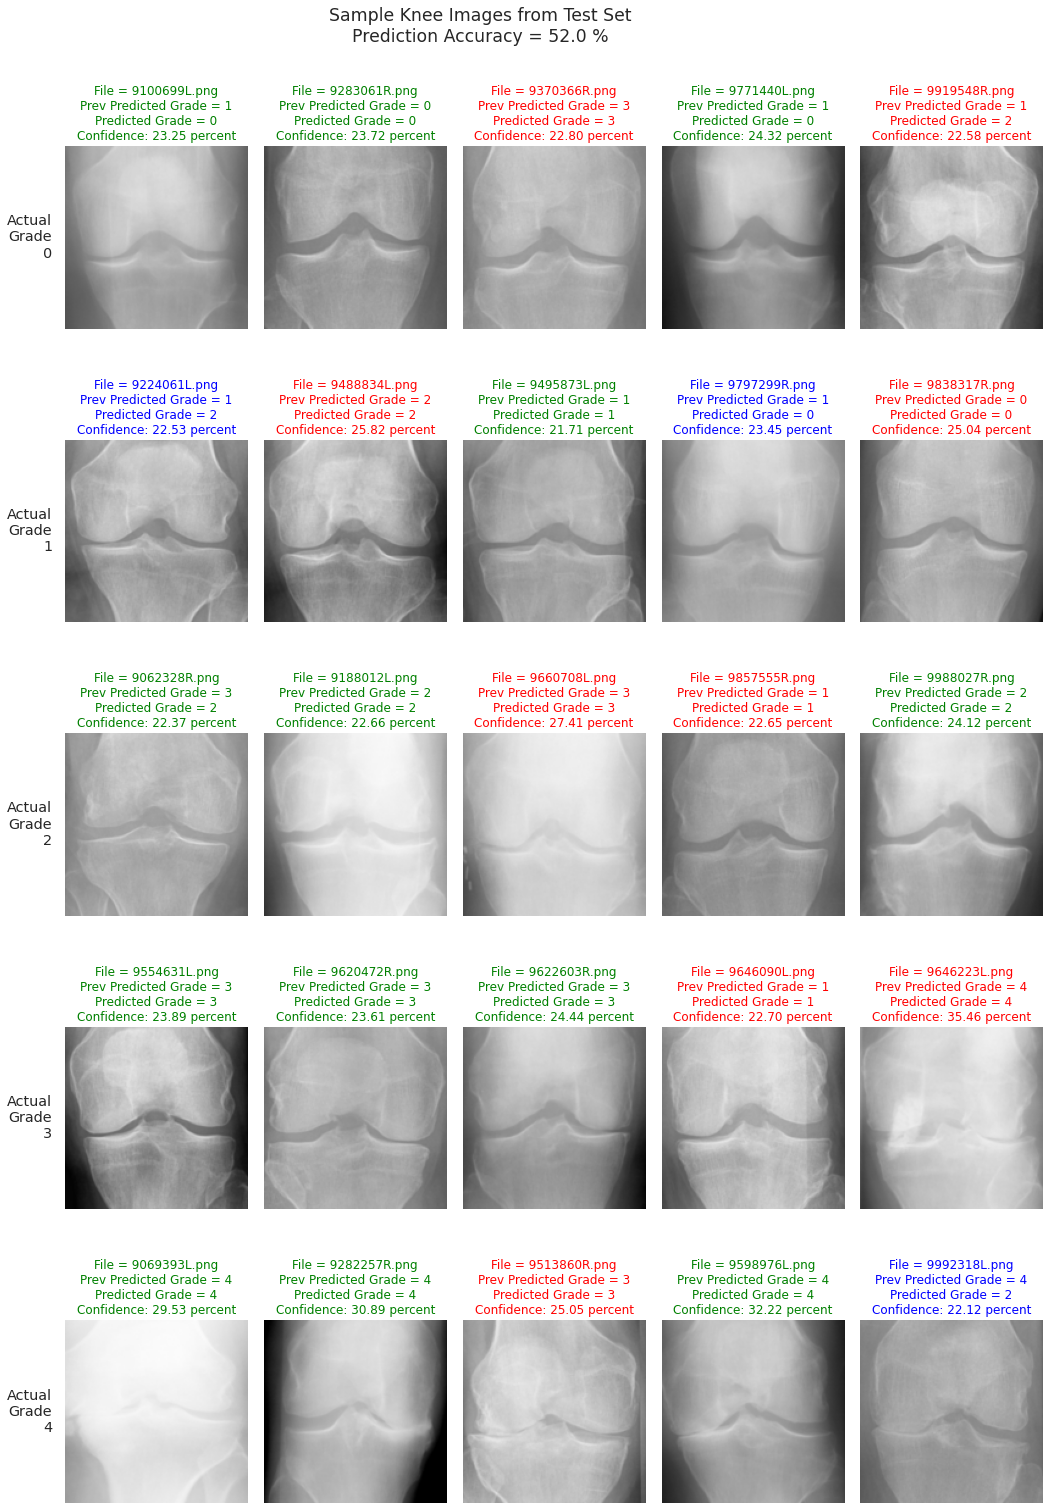

In [55]:
# plot the images

rows = ['Actual\nGrade\n{}'.format(grade) for grade in range(5)]

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(16, 22))

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.05), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='x-large', ha='right', va='center')

for i in range(5):
    for j in range(5):
        img_num = i*5 + j
        ax = axes[i, j]
        
        # can't just turn off the axis if we want to keep y label
        # must turn each element of axis off
        ax.xaxis.set_visible(False)
        plt.setp(ax.spines.values(), visible=False)
        ax.tick_params(left=False, labelleft=False)
        
        ax.imshow(test_sample_images[img_num].squeeze().astype('uint8'))
        
        file_name = test_sample_files[img_num][1]
        prev_pred_grade = test_sample_prediction_labels[img_num]
        pred_grade = fine_tuned_test_sample_prediction_labels[img_num]
        score = 100*np.max(tf.nn.softmax(fine_tuned_test_sample_predictions[img_num]))
        title = "File = {}\nPrev Predicted Grade = {}\nPredicted Grade = {}\nConfidence: {:.2f} percent".format(file_name, prev_pred_grade, pred_grade, score)
        
        # if correctly predicted, set title color to green; if previously correct, but now incorrect, set color to blue
        # note that i == actual grade
        title_color = 'red'
        if pred_grade == i:
            title_color = 'green'
        elif prev_pred_grade == i:
            title_color = 'blue'
        ax.set_title(title, color=title_color) 
_ = plt.suptitle('Sample Knee Images from Test Set\nPrediction Accuracy = {} %'.format(fine_tuned_test_sample_accuracy_score), size='xx-large')
plt.tight_layout(rect=[0.08, 0, 1, 0.95])